This notebook creates the maps of the environmental variables, the El Nino chart and the ACLED kernel density maps.

In [3]:
import os
import math
from glob import glob
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as clrs
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import ColorbarBase
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from textwrap import wrap 

env_names={'rfe':'Rainfall', 'LST': 'LST','NDVI': 'NDVI'}

cmaps={'rfe':'PuOr', 'LST': 'coolwarm','NDVI': 'BrBG'}
dot_colors={'rfe': 'lime', 'LST':'lime', 'NDVI': 'red'}

countries = ['nigeria','ethiopia', 'southafrica', 'kenya']

country_names={'kenya': 'Kenya', 'nigeria': 'Nigeria', 'ethiopia': 'Ethiopia', 'southafrica': 'South Africa'}
country_codes={'kenya': 'KEN', 'nigeria': 'NIG', 'ethiopia': 'ETH', 'southafrica': 'SAF'}

world_countries = gpd.read_file('GIS/world_countries.shp')

Environmental dynamics map. 

Set the "env_var" variable to either 'rfe', 'LST' or 'NDVI'.

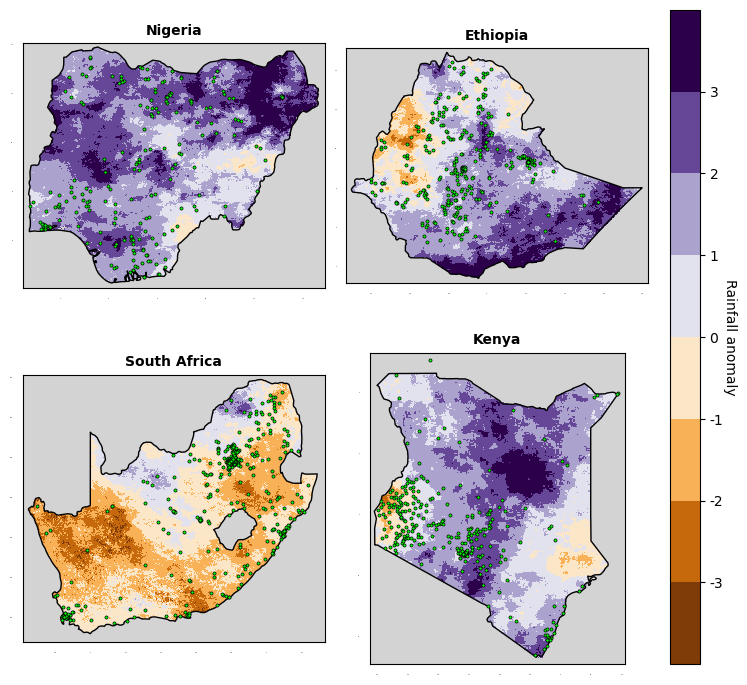

In [3]:
env_var='rfe'
env_name=env_names[env_var]
cmap_str=cmaps[env_var]
dot_color=dot_colors[env_var]

cmap_cont=plt.get_cmap(cmap_str)

cmaplist = [cmap_cont(i) for i in np.linspace(0,1.0, 8)]

cmap = clrs.LinearSegmentedColormap.from_list(
    env_var+'_cmap', cmaplist, 8)

bounds = np.concatenate(([-100],np.arange(-3, 4, 1),[100]))
norm = clrs.BoundaryNorm(bounds, 8)

fig = plt.figure(figsize=(10.5, 8.5))
gs = GridSpec(2, 3, width_ratios=[1,1,0.1], height_ratios=[1,1])

# Looping over the countries
for i in range(0,len(countries)):
    
    ax=fig.add_subplot(gs[math.floor(i/2),i%2])
    country=countries[i]
    raster_name='Maps/'+country+'_'+env_var+'_anoms.tif' # Environmental variable image
    
    country_name=country_names[country]
    country_code=country_codes[country]
    raster=rxr.open_rasterio(raster_name)
    raster.rio.write_crs(4326, inplace=True)
    
    country_polygon=world_countries.to_crs('EPSG:4326').loc[world_countries['COUNTRY']==country_name,'geometry'] # Country polygon
    
    x_min=np.amin(raster.coords['x'])
    x_max=np.amax(raster.coords['x'])
    y_min=np.amin(raster.coords['y'])
    y_max=np.amax(raster.coords['y'])

    if(country=='kenya'):
        y_max=5.1
    elif(country=='southafrica'):
        y_min=-35
        x_max=33
    
    ax.set_facecolor("lightgrey")

    class_plot=raster.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False)

    poly_plot=country_polygon.plot(ax=ax, facecolor="none", edgecolor='black')

    centroids=gpd.read_file('GIS/'+country_code+'/'+country_code+'_R8_PSU_centroids.shp').to_crs('EPSG:4326')
    centroid_plot=centroids.plot(ax=ax, markersize=5, facecolor=dot_color, edgecolor='black', linewidth=0.5)

    ax.set_xlabel(r'', fontsize=13)
    ax.set_ylabel(r'', fontsize=13)
    ax.set_title(country_name, fontsize=10, fontweight='bold')
    ax.tick_params(labelsize=0, left = False, bottom=False)
    x_off=(x_max-x_min)/50
    y_off=(y_max-y_min)/50
    
    ax.set_xlim((x_min-x_off,x_max+x_off))
    ax.set_ylim((y_min-y_off,y_max+y_off))
 
ax6=plt.subplot(gs[:,2]  )
cbar = ColorbarBase(ax6, cmap=cmap, norm=norm)

cbar.set_ticks(bounds[1:-1])
cbar.set_ticklabels(ticklabels=bounds[1:-1], fontsize=10)
cbar.set_label(env_name+' anomaly', rotation=270, labelpad=10)

plt.subplots_adjust(wspace=0.1, right=0.77, hspace=0.1)

plt.show()
fig.savefig('../Drafts/Images/'+env_var+'_anoms.png', bbox_inches='tight')

El Nino chart

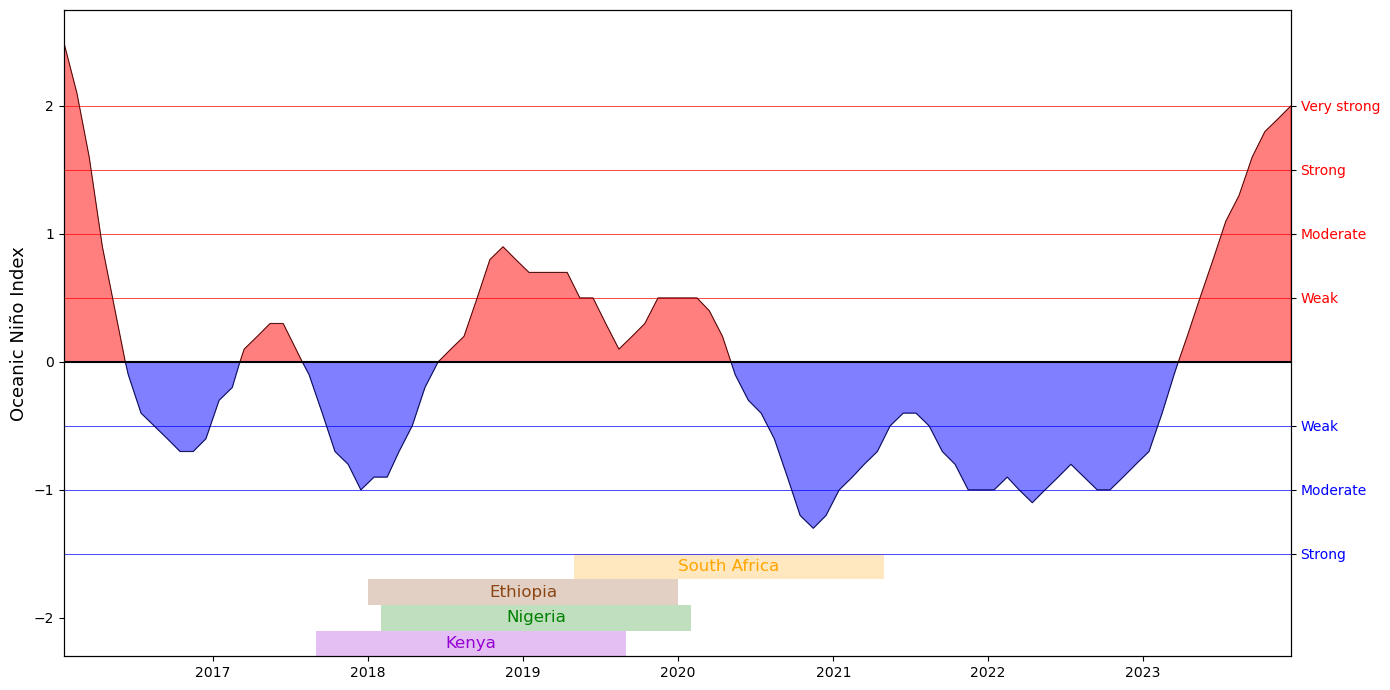

In [82]:
from datetime import date, datetime

oni_arr=np.loadtxt('oni.txt')

country_years={'kenya': 2019, 'nigeria': 2020, 'ethiopia': 2019, 'southafrica': 2021}
country_months={'kenya': 8, 'nigeria': 1, 'ethiopia': 12, 'southafrica': 4}
country_names={'kenya': 'Kenya', 'nigeria': 'Nigeria', 'ethiopia': 'Ethiopia', 'southafrica': 'South Africa'}
country_colors={'kenya': 'darkviolet', 'nigeria': 'g', 'ethiopia': 'saddlebrown', 'southafrica': 'orange'}
win_len=2

countries=list(country_years.keys())

year_num = oni_arr.shape[0]
years=np.repeat(np.arange(1950, 1950+year_num, 1, dtype=int),12)
months=np.tile(np.arange(1,13,1,dtype=int),year_num)

dates = np.array([date(years[i],months[i],15) for i in range(0,year_num*12)])

oni_arr2=oni_arr.flatten()

oni_diff2 = np.sign(oni_arr2[1:])-np.sign(oni_arr2[:-1])

zero_indices=np.flatnonzero(np.abs(oni_diff2)==2)

zero_dates = (dates[zero_indices+1]-dates[zero_indices])/(oni_arr2[zero_indices+1]-oni_arr2[zero_indices])*(-oni_arr2[zero_indices])+dates[zero_indices]

oni_arr2=np.insert(oni_arr2, zero_indices+1,0)
dates=np.insert(dates, zero_indices+1, zero_dates)

fig, ax1 = plt.subplots(figsize=(14,7))
ax2 = ax1.twinx()
#ax3 = ax1.twiny()
ax1.fill_between(dates,oni_arr2, where=oni_arr2>=0, color='red', alpha=0.5)
ax1.fill_between(dates,oni_arr2, where=oni_arr2<=0, color='blue', alpha=0.5)

ax1.axhline(0, color='k')
ax1.axhline(0.5, color='red',linewidth=0.5)
ax1.axhline(1, color='red',linewidth=0.5)
ax1.axhline(1.5, color='red',linewidth=0.5)
ax1.axhline(2, color='red',linewidth=0.5)
ax1.axhline(-0.5, color='blue',linewidth=0.5)
ax1.axhline(-1, color='blue',linewidth=0.5)
ax1.axhline(-1.5, color='blue',linewidth=0.5)

ax1.plot(dates, oni_arr2, 'k', linewidth=0.5)

ax2.set_yticks([-1.5,-1,-0.5,0.5,1,1.5,2])
ax2.set_yticklabels(['Strong','Moderate','Weak','Weak','Moderate','Strong','Very strong'])
colors = ['b','b','b', 'r', 'r','r','r']
for ytick, color in zip(ax2.get_yticklabels(), colors):
    ytick.set_color(color)

date_starts=[]
date_widths=[]
for key in country_years.keys():
    country_year=country_years[key]
    country_month=country_months[key]

    month_start = (country_month % 12) + 1
    year_start = country_year - (country_month!=12) - (win_len-1)

    date_starts.append(date(year_start,month_start,1))
    date_widths.append(date(year_start+win_len,month_start,1)-date(year_start,month_start,1))


    #ax1.axvline(date(year_start,month_start,1),color=country_color, label=country_name,linewidth=3)
    #ax2.axvline(date(year_start+win_len,month_start,1),color=country_color, label=country_name,linewidth=3)

y_bars=np.array([-2,-1.8,-1.6,-1.4])-0.2
bars=ax1.barh(y_bars,height=0.2,width=date_widths, left=date_starts, color=country_colors.values(), alpha=0.25)

for i in range(0,len(countries)):
    country=countries[i]
    country_name=country_names[country]
    country_color=country_colors[country]

    ax1.text(date_starts[i]+date_widths[i]/2,y_bars[i],country_name, color=country_color, ha='center', va='center', fontsize=12)

    

#ax1.bar_label(bars,country_names.values(), color=list(country_colors.values()))
ax1.set_ylim(-2.3,2.75)
ax2.set_ylim(-2.3,2.75)
ax1.set_xlim(date(2016,1,15),date(2023,12,15))

ax1.set_ylabel('Oceanic Ni\u00F1o Index', fontsize=13)

#plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('../Drafts/Images/enso.png')





In [ ]:
Ecological zones map

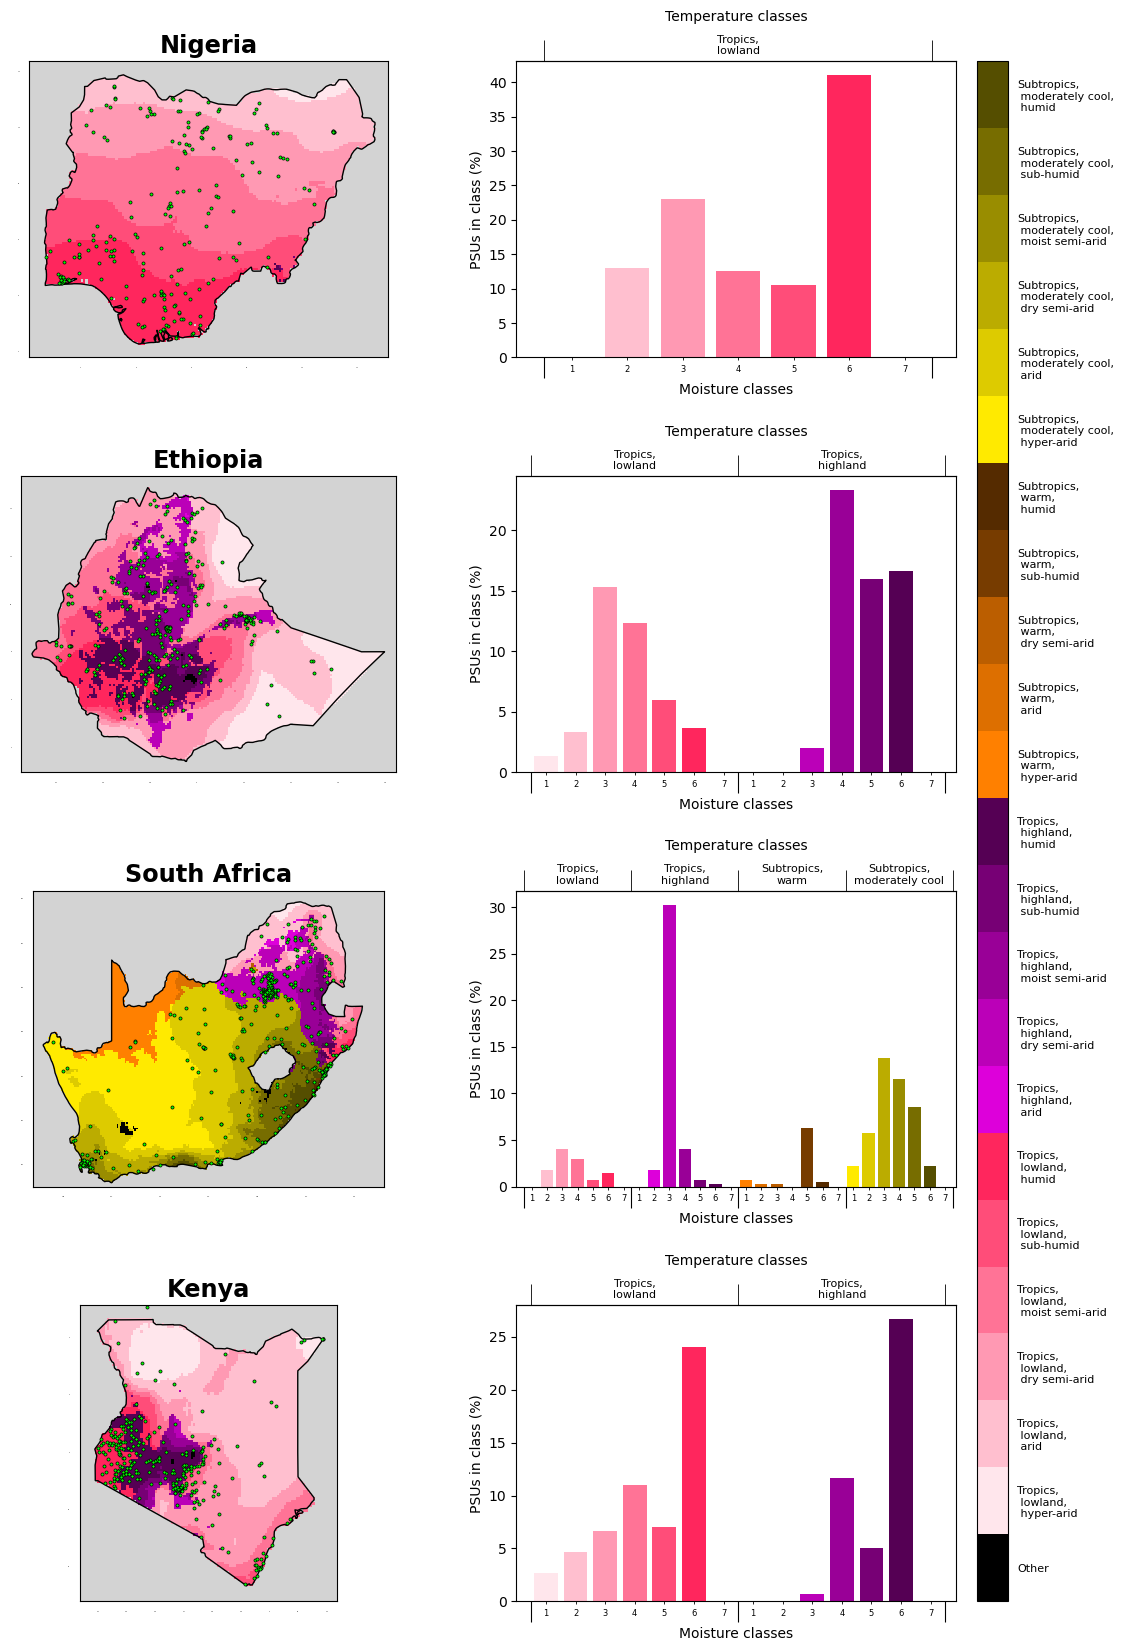

In [12]:
countries=gpd.read_file('GIS/world_countries.shp')

from matplotlib.colors import hsv_to_rgb, ListedColormap, BoundaryNorm

thz_classes = np.char.array([
    'Tropics, lowland',
    'Tropics, highland',
    'Subtropics, warm',
    'Subtropics, moderately cool',
    'Subtropics, cool',
    'Temperate, moderate',
    'Temperate, cool',
    'Boreal/Cold, no permafrost',
    'Boreal/Cold, with permafrost',
    'Arctic, very cold'
])

mst_classes = np.array([
    'hyper-arid',
    'arid',
    'dry semi-arid',
    'moist semi-arid',
    'sub-humid',
    'humid',
    'per-humid'
])

thz_mst_classes = np.repeat(thz_classes, len(mst_classes))+', '+np.tile(mst_classes, len(thz_classes))

hues = np.array([
    344,
    300,
    30,
    55,
    90,
    170,
    200,
    240,
    281,
    313
])

sats = np.array([
    True,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
])

scale_arr=np.linspace(0.1,1,len(mst_classes))
sats_bool=np.repeat(sats, len(mst_classes))
sats_scale=np.tile(np.linspace(0.1,1,len(mst_classes)), len(thz_classes))
value_scale=np.tile(1-np.linspace(0,0.8,len(mst_classes)), len(thz_classes))

cmap_arr = np.ones((len(thz_classes)*len(mst_classes),3))
cmap_arr[:,0] = np.repeat(hues, len(mst_classes))/359
cmap_arr[:,1][np.flatnonzero(sats_bool)] = sats_scale[np.flatnonzero(sats_bool)]
cmap_arr[:,2][np.flatnonzero(~sats_bool)] = value_scale[np.flatnonzero(~sats_bool)]

cmap_rgb_arr = hsv_to_rgb(cmap_arr)
cmap_rgb_arr = np.hstack([cmap_rgb_arr, np.ones(len(thz_classes)*len(mst_classes))[:,np.newaxis]])

all_values = np.repeat(np.arange(len(thz_classes))+1, len(mst_classes))*100+np.tile(np.arange(len(mst_classes))+1, len(thz_classes))

raster_names=['mst_thz_nigeria.tif',
              'mst_thz_ethiopia.tif',
              'mst_thz_southafrica.tif',
              'mst_thz_kenya.tif']
country_names=['Nigeria',
               'Ethiopia',
               'South Africa',
               'Kenya']
country_codes=['NIG','ETH','SAF','KEN']
country_strings=['nigeria','ethiopia','southafrica','kenya']

codes_dict = dict()

for i in range(0,len(country_names)):
    country_code=country_codes[i]
    country_name=country_names[i]
    country_str=country_strings[i]

    aez_df=pd.read_csv('Afrobarometer/'+country_code+'/'+country_str+'_AEZ_PSU.csv')

    codes_dict[country_code] = aez_df['AEZ_Num'].value_counts(normalize=True).to_dict()

gaez_codes=[]
for i in range(0,len(country_names)):
    country_code=country_codes[i]
    gaez_codes+=list(codes_dict[country_code].keys())
unique_codes=np.unique(np.array(gaez_codes))
    

raster_list=[]
unique_values=np.zeros(0, dtype=int)

for i in range(0,len(country_names)):
    raster_name=raster_names[i]
    country_name=country_names[i]
    country_code=country_codes[i]
    
    mst_thz = rxr.open_rasterio('Ecological_areas/'+country_code+'/'+raster_name)
    
    uniq, value_counts = np.unique(mst_thz, return_counts=True)
    value_counts=value_counts/np.sum(value_counts)

    uniq_args=np.flatnonzero(np.logical_or(value_counts>0.01,np.isin(uniq,unique_codes)))
    uniq=uniq[uniq_args]
    value_counts=value_counts[uniq_args]
    
    
    value_counts=value_counts[np.flatnonzero(uniq!=0)]
    uniq=uniq[np.flatnonzero(uniq!=0)]
    
    mst_thz=mst_thz.where(mst_thz.values!=0)
        
    unique_values=np.append(unique_values, uniq)
    
    raster_list.append(mst_thz)
    
unique_values = np.unique(unique_values)

cmap_rgb_arr1=cmap_rgb_arr[np.flatnonzero(np.isin(all_values, unique_values))]
bounds=all_values[np.flatnonzero(np.isin(all_values, unique_values))]
labels=thz_mst_classes[np.flatnonzero(np.isin(all_values, unique_values))]
labels= np.array([ l.replace(',',',\n') for l in labels])

unique_values = np.append(1,unique_values)
cmap_rgb_arr1 = np.vstack([np.array([0,0,0,1]),cmap_rgb_arr1])
bounds=np.append(1,bounds)
labels=np.append('Other',labels)

cmap = ListedColormap(cmap_rgb_arr1,name='thz_mst_colormap')
cmap.set_bad('lightgrey')

bounds=np.append(bounds,1100)
norm = BoundaryNorm(bounds, cmap.N)


fig, ax =plt.subplots(len(country_names),2, figsize=(15,20))

for i in range(0,len(country_names)):
    raster_name=raster_names[i]
    country_name=country_names[i]
    country_code=country_codes[i]
    
    mst_thz = raster_list[i]
    
    mst_thz=mst_thz.where(np.logical_or(np.isin(mst_thz.values,unique_values),np.isnan(mst_thz.values)), 1)
    
    x_min=np.amin(mst_thz.coords['x'])
    x_max=np.amax(mst_thz.coords['x'])
    y_min=np.amin(mst_thz.coords['y'])
    y_max=np.amax(mst_thz.coords['y'])
    
    country=countries.loc[countries['COUNTRY'] == country_name].to_crs(epsg=4326)

    ax[i,0].set_facecolor("lightgrey")
    class_plot=mst_thz.plot(ax=ax[i,0], cmap=cmap, norm=norm, add_colorbar=False)

    poly_plot=country.plot(ax=ax[i,0], facecolor="none", edgecolor='black')

    centroids=gpd.read_file('GIS/'+country_code+'/'+country_code+'_R8_PSU_centroids.shp').to_crs('EPSG:4326')
    centroid_plot=centroids.plot(ax=ax[i,0], markersize=5, facecolor='lime', edgecolor='black', linewidth=0.5)
    
    ax[i,0].set_xlabel(r'')
    ax[i,0].set_ylabel(r'')
    ax[i,0].tick_params(labelsize=0, left = False, bottom=False)
    
    if(country_name=='South Africa'):
        ax[i,0].set_ylim((-35,y_max+0.5))
        ax[i,0].set_xlim((x_min-0.5,34))
    else:
        ax[i,0].set_xlim((x_min-0.5,x_max+0.5))
        ax[i,0].set_ylim((y_min-0.5,y_max+0.5))
        
    ax[i,0].set_title(country_name, fontsize='xx-large', fontweight='bold')

    uniq = np.array(list(codes_dict[country_code].keys()))
    value_counts = np.array(list(codes_dict[country_code].values()))

    all_value_counts=np.zeros(len(all_values), dtype=float)
    all_value_counts[np.searchsorted(all_values, uniq)]=value_counts
    
    all_value_counts = all_value_counts*100
    
    ax[i,1].bar(np.arange(len(all_value_counts)),all_value_counts, color=cmap_rgb_arr)

    ax[i,1].set_xticks(np.arange(0,len(all_value_counts),1), minor=True)
    ax[i,1].set_xticks(np.arange(0,len(all_value_counts),len(mst_classes))-0.5, minor=False)
    ax[i,1].set_xticklabels(np.repeat('',len(all_value_counts)/len(mst_classes)), minor=False)
    ax[i,1].set_xticklabels(np.tile(np.arange(1,8,1),len(thz_classes)), minor=True)
    thz_labels= np.array([ '\n'.join(wrap(l, 15)) for l in thz_classes])
    tick_lengths=np.tile(np.array([1,0]),len(all_value_counts))
    ax[i,1].tick_params(length=15, which='major', axis='x')
    ax[i,1].tick_params(labelsize=6, which='minor', axis='x')
    ax[i,1].set_xlabel('Moisture classes', labelpad=0)
    
    ax2=ax[i,1].secondary_xaxis("top")
    ax2.set_xticks(np.arange(0,len(all_value_counts),len(mst_classes))+len(mst_classes)/2.0-0.5, minor=False)
    ax2.set_xticks(np.arange(0,len(all_value_counts),len(mst_classes))-0.5, minor=True)
    ax2.set_xticklabels(thz_labels, minor=False)
    ax2.tick_params(labelsize=8, length=0, which='major')
    ax2.tick_params(length=15, which='minor')
    ax2.set_xlabel('Temperature classes', labelpad=10)
    
    
    ax[i,1].set_ylabel('PSUs in class (%)')

    ax[i,1].set_xlim((-1, len(mst_classes)*(int(np.amax(np.flatnonzero(all_value_counts)/len(mst_classes)))+1)*0.99))
    


cbar=fig.colorbar(class_plot, ax=ax.ravel().tolist(), aspect=50)
cbar.ax.set_yticks((bounds[1:]+bounds[0:-1])/2)
cbar.ax.set_yticklabels(labels)
cbar.ax.tick_params(labelsize=8, width=0)

for axe in ax[:,0]:
    axe.set_anchor('C')    
plt.subplots_adjust(wspace=0.2, right=0.77, hspace=0.4)

plt.show()

ACLED kernel density map

<xarray.DataArray ()>
array(0.04069272, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(0.05830601, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(0.0443636, dtype=float32)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(0.09383568, dtype=float32)
Coordinates:
    spatial_ref  int64 0


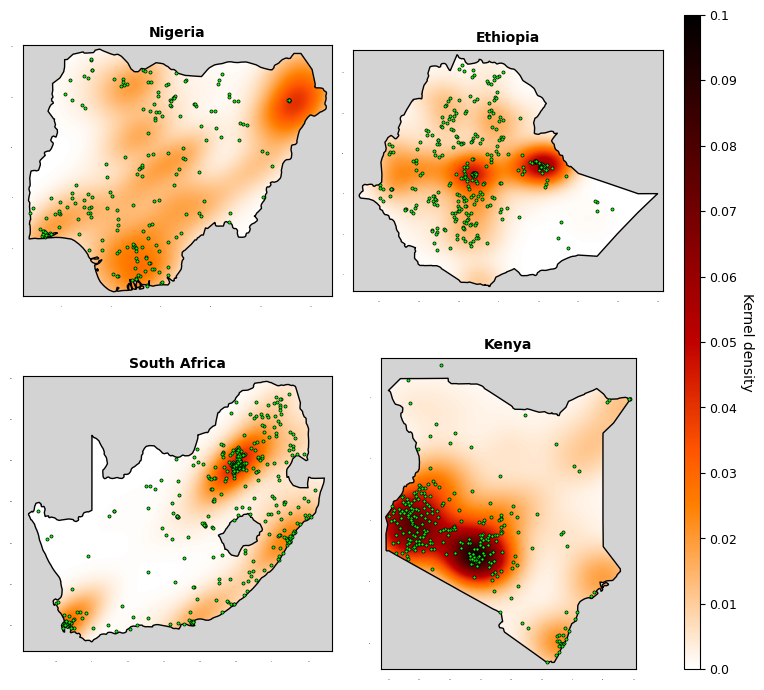

In [27]:
fig = plt.figure(figsize=(10.5, 8.5))
gs = GridSpec(2, 3, width_ratios=[1,1,0.05], height_ratios=[1,1])

norm = plt.Normalize(0, 0.1)

for i in range(0,len(countries)):
    
    ax=fig.add_subplot(gs[math.floor(i/2),i%2])
    country=countries[i]
    raster_name='ACLED/'+country+'_ACLED.tif'
    country_name=country_names[country]
    country_code=country_codes[country]
    raster=rxr.open_rasterio(raster_name)

    raster.rio.write_crs(4326, inplace=True)
    country_polygon=world_countries.to_crs('EPSG:4326').loc[world_countries['COUNTRY']==country_name,'geometry']

    raster = raster.rio.clip(country_polygon)

    print(np.amax(raster))
    
    x_min=np.amin(raster.coords['x'])
    x_max=np.amax(raster.coords['x'])
    y_min=np.amin(raster.coords['y'])
    y_max=np.amax(raster.coords['y'])

    if(country=='kenya'):
        y_max=5.1
    elif(country=='southafrica'):
        y_min=-35
        x_max=33
    
    ax.set_facecolor("lightgrey")

    
    class_plot=raster.plot(ax=ax, cmap="gist_heat_r", norm=norm, add_colorbar=False)

    poly_plot=country_polygon.plot(ax=ax, facecolor="none", edgecolor='black')

    centroids=gpd.read_file('GIS/'+country_code+'/'+country_code+'_R8_PSU_centroids.shp').to_crs('EPSG:4326')
    centroid_plot=centroids.plot(ax=ax, markersize=5, facecolor=dot_color, edgecolor='black', linewidth=0.5)

    ax.set_xlabel(r'', fontsize=13)
    ax.set_ylabel(r'', fontsize=13)
    ax.set_title(country_name, fontsize=10, fontweight='bold')
    ax.tick_params(labelsize=0, left = False, bottom=False)
    x_off=(x_max-x_min)/50
    y_off=(y_max-y_min)/50
    
    ax.set_xlim((x_min-x_off,x_max+x_off))
    ax.set_ylim((y_min-y_off,y_max+y_off))
    #ax.set(adjustable='box', aspect='equal')

ax6=plt.subplot(gs[:,2] )
cbar = ColorbarBase(ax6, cmap="gist_heat_r", norm=norm)

#cbar=fig.colorbar(class_plot, ax=gs[0,0], aspect=50)
cbar.set_ticks(np.arange(0,0.11,0.01))
cbar.set_ticklabels(np.arange(0,0.11,0.01), fontsize=9)
cbar.set_label('Kernel density', rotation=270, labelpad=12)

plt.subplots_adjust(wspace=0.1, right=0.77, hspace=0.1)

#cbar.ax.set_yticklabels(np.append(labels,''))

#plt.setp(cbar.ax.get_yticklabels()[::1], visible=True)

#plt.tight_layout()
plt.show()
fig.savefig('../Drafts/Images/ACLED_heatmap.png', bbox_inches='tight')